In [5]:
pip install dask
pip install delayed imbalanced-learn
pip install autocorrect

Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import gzip
import json
import numpy as np
import regex as re
import matplotlib.pyplot as plt
import seaborn as sns
import dask 
import dask.dataframe as dd
import imblearn
from collections import Counter

import time
%matplotlib inline

Our data is in the form of zipped json files, so extract them and load them into pandas.

In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield json.loads(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')


#df = getDF('Gift_Cards_5.json.gz')
#df = df[df['reviewText'].notna()]
#df.info()
#display(df.head())

In [4]:
elec = getDF('Electronics_5_2018.json.gz')

#We don't have much use for any records without reviews
elec = elec[elec['reviewText'].notna()]

elec.info()
display(elec.head())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6738237 entries, 0 to 6739589
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   overall         float64
 1   vote            object 
 2   verified        bool   
 3   reviewTime      object 
 4   reviewerID      object 
 5   asin            object 
 6   style           object 
 7   reviewerName    object 
 8   reviewText      object 
 9   summary         object 
 10  unixReviewTime  int64  
 11  image           object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 623.3+ MB


,overall,vote,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,image
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,{'Format:': ' Hardcover'},D. C. Carrad,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,NaN
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,{'Format:': ' Kindle Edition'},Evy,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,NaN
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,{'Format:': ' Paperback'},Kcorn,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,NaN
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,{'Format:': ' Hardcover'},Caf Girl Writes,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,NaN
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,{'Format:': ' Hardcover'},W. Shane Schmidt,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,NaN


As a helpful reminder from the data doc, we know that:

reviewerID - ID of the reviewer, e.g. A2SUAM1J3GNN3B

asin - ID of the product, e.g. 0000013714

reviewerName - name of the reviewer

vote - helpful votes of the review

style - a disctionary of the product metadata, e.g., "Format" is "Hardcover"

reviewText - text of the review

overall - rating of the product

summary - summary of the review

unixReviewTime - time of the review (unix time)

reviewTime - time of the review (raw)

image - images that users post after they have received the product

In [7]:
elec_ddf = dd.from_pandas(elec, npartitions = 100)

## Target Variable Distribution

Before we go modeling, we want to get an idea of how our data is distributed. We are mainly interested in the rating of the product, the review itself, and potentially the review summary as well as users themselves.

Let's start by looking at how our ground truths, the ratings, are distributed.

In [11]:
elec['overall'].value_counts()

#using dask
#elec_ddf.overall.value_counts().compute()

5.0    4322520
4.0    1137229
3.0     504712
1.0     467117
2.0     306659
Name: overall, dtype: int64

<AxesSubplot:xlabel='overall', ylabel='count'>

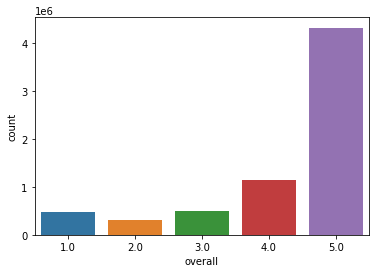

In [76]:
sns.countplot(elec['overall'])

Our reviews are highly skewed. This is not necessarily a problem with the sample- people may simply feel more comfortable rating things positively, or there may simply be fewer very bad experiences. However, this is not ideal for us, as we don't want our algorithm to become biased toward classifying reviews as positive (as it may be able to generally get more samples correct that way). Since we already have a massive abundance of data, we might want to try downsampling some of the higher ratings to make things a bit more even.

But first, let's explore the data a bit more- some of our cleaning might make our data a bit more balanced naturally.

In [16]:
# let's copy our dataframe and get rid of the style and image columns, which are not very useful and rather unwieldy

el = elec.copy()

In [17]:
el.drop(['style', 'reviewerName', 'image'], inplace = True, axis=1)

**NOTE:** Before cleaning, our data has 5 reviews from each user. Do we want to try to normalize the ratings by the other ratings users did, turning our problem into a continuous prediction problem rather than classification?

## Verified distribution

In [74]:
el['verified'].value_counts()

True     6037146
False     701091
Name: verified, dtype: int64

It seems that while most of our reviews are verified, we have a significant amount of unverified reviews. Only using verified reviews will make our data less susceptible to bots and trolls, but may end up excluding a subpopulation of "real" shoppers (for instance, people reviewing something someone else bought for them, or people who received some sort of discount).

## Text Cleaning

In [2]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from autocorrect import Speller

In [ ]:
el = pd.read_csv('electronics_shortened')

In [38]:
test= el.iloc[:100]
test

,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,num_words
0,0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,this is the best novel i have read in 2 or 3 y...,A star is born,937612800,197
1,1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,"pages and pages of introspective , in the s...",A stream of consciousness novel,1382486400,81
2,2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,this is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,362
3,3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,what gorgeous language ! what an incredible...,The most beautiful book I have ever read!,968025600,233
4,4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,i was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,283
...,...,...,...,...,...,...,...,...,...,...,...
95,95,5.0,NaN,True,"09 11, 2014",A1ZZFX6SHV84ZU,0594033926,very nice item,Five Stars,1410393600,3
96,96,5.0,NaN,True,"09 11, 2014",A34JP15SDQIII6,0594033926,since b and n no longer carry the book color ...,"If you need one, get this one",1410393600,26
97,97,5.0,NaN,True,"02 18, 2016",A3HN9PMEGAM6JT,0594459451,works great with book color,Five Stars,1455753600,5
98,98,5.0,NaN,True,"02 11, 2016",A1CHTT6E3NV5YL,0594459451,the 90 degree connector is a bonus that allows...,Works great on my Wife's older model Nook Color.,1455148800,49


In [39]:
%%time

test['reviewText'] = test['reviewText'].apply(lambda x: clean_text(x))

Wall time: 64.8 ms


C:\Users\galla\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [34]:
%%time

test_ddf = dd.from_pandas(test, npartitions = 52)

Wall time: 3.99 ms


In [35]:
%%time

test_ddf['reviewText'] = test_ddf['reviewText'].apply(lambda x: clean_text(x))

C:\Users\galla\Anaconda3\lib\site-packages\dask\dataframe\core.py:3207: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=('reviewText', 'object'))

  warnings.warn(meta_warning(meta))


Wall time: 691 ms


In [32]:
test_ddf['reviewText']

Dask Series Structure:
npartitions=50
0     object
2        ...
       ...  
98       ...
99       ...
Name: reviewText, dtype: object
Dask Name: getitem, 250 tasks

In [27]:
%%time
test_ddf.compute()

Wall time: 24.6 s


,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,num_words
0,0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,this is the best novel i have read in 2 or 3 y...,A star is born,937612800,197
1,1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,"pages and pages of introspective , in the...",A stream of consciousness novel,1382486400,81
2,2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,this is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,362
3,3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,what gorgeous language ! what an incredib...,The most beautiful book I have ever read!,968025600,233
4,4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,i was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,283
...,...,...,...,...,...,...,...,...,...,...,...
95,95,5.0,NaN,True,"09 11, 2014",A1ZZFX6SHV84ZU,0594033926,very nice item,Five Stars,1410393600,3
96,96,5.0,NaN,True,"09 11, 2014",A34JP15SDQIII6,0594033926,since b and n no longer carry the book color ...,"If you need one, get this one",1410393600,26
97,97,5.0,NaN,True,"02 18, 2016",A3HN9PMEGAM6JT,0594459451,works great with book color,Five Stars,1455753600,5
98,98,5.0,NaN,True,"02 11, 2016",A1CHTT6E3NV5YL,0594459451,the 90 degree connector is a bonus that allows...,Works great on my Wife's older model Nook Color.,1455148800,49


We want to clean the text in the following way before vectorizing and embedding:

**Lowercase all text.** We don't want multiple different versions of the same word diluting its embedding. *Note: Should we worry about losing a potential sentence boundary indicator?*

**Spellcheck words.** This one's self-explanatory. *Note: may need to revisit when we spellcheck, see gibberish detection later* 

**Expand contractions into full word pairs.** Theoretically, pretrained embedding models may be able to learn context for contractions like any other word, but it should also be able to learn the word pair meanings in similar ways. To avoid redundancy and to make regex-based tokenizing easier later, we should expand these out. Contraction dict taken from https://www.analyticsvidhya.com/blog/2020/08/information-retrieval-using-word2vec-based-vector-space-model/

**Get rid of links.** We are dealing with reviews where people may be trying to link to other products, etc. These are hyperspecific and thus are not going to be useful for embeddings.

**Get rid of weird characters. Add spaces before and after kept punctuation** This one is a bit tough. We don't want to get rid of all punctuation, as if we tokenize some punctuation it can add depth to our embeddings (a period marking the end of a sentence, an exclamation adding emphasis, etc.). However, we want to make sure especially odd symbols, such as those that might appear from faulty encodings, is removed. We don't simply want to do this with our tokenizer, in case odd encodings occur in the middle of words (which might break them up into gibberish). We also want to tokenize punctuation independently from the attached words, to avoid standardization issues, so we need to separate them. We were fairly liberal with the punctuation we kept. 

*Note: Should we get rid of numbers?*

*Note: How should we handle underscores?*

In [15]:
#Spellchecking using the autocorrect package.

#check = Speller(lang = 'en')

#def fixSentence(sentence):
    #return check(sentence)

#Create a dictionary of english contractions and their expanded forms.
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not","can't": "can not","can't've": "cannot have",
"'cause": "because","could've": "could have","couldn't": "could not","couldn't've": "could not have",
"didn't": "did not","doesn't": "does not","don't": "do not","hadn't": "had not","hadn't've": "had not have",
"hasn't": "has not","haven't": "have not","he'd": "he would","he'd've": "he would have","he'll": "he will",
"he'll've": "he will have","how'd": "how did","how'd'y": "how do you","how'll": "how will","i'd": "i would",
"i'd've": "i would have","i'll": "i will","i'll've": "i will have","i'm": "i am","i've": "i have",
"isn't": "is not","it'd": "it would","it'd've": "it would have","it'll": "it will","it'll've": "it will have",
"let's": "let us","ma'am": "madam","mayn't": "may not","might've": "might have","mightn't": "might not",
"mightn't've": "might not have","must've": "must have","mustn't": "must not","mustn't've": "must not have",
"needn't": "need not","needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
"oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
"shan't've": "shall not have","she'd": "she would","she'd've": "she would have","she'll": "she will",
"she'll've": "she will have","should've": "should have","shouldn't": "should not",
"shouldn't've": "should not have","so've": "so have","that'd": "that would","that'd've": "that would have",
"there'd": "there would","there'd've": "there would have",
"they'd": "they would","they'd've": "they would have","they'll": "they will","they'll've": "they will have",
"they're": "they are","they've": "they have","to've": "to have","wasn't": "was not","we'd": "we would",
"we'd've": "we would have","we'll": "we will","we'll've": "we will have","we're": "we are","we've": "we have",
"weren't": "were not","what'll": "what will","what'll've": "what will have","what're": "what are",
"what've": "what have","when've": "when have","where'd": "where did",
"where've": "where have","who'll": "who will","who'll've": "who will have","who've": "who have",
"why've": "why have","will've": "will have","won't": "will not","won't've": "will not have",
"would've": "would have","wouldn't": "would not","wouldn't've": "would not have","y'all": "you all",
"y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
"you'd": "you would","you'd've": "you would have","you'll": "you will","you'll've": "you will have",
"you're": "you are","you've": "you have"}

# Regular expression for finding contractions
contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contraction(text, contractions_dict = contractions_dict):
    
    #for anything that matches the re we defined earlier for the contraction keys, replace with the value
    
    def replace(match):
        return contractions_dict[match.group(0)]
    
    return contractions_re.sub(replace, text)

def clean_text(text):
    
    # make sure the text is of type str if not for some weird reason, then set to lowercase. 
    text = str(text).lower()
    
    #Spell check
    #text = fixSentence(text)
    
    #Expand contractions
    text = expand_contraction(text)
    
    #Remove links. If any text starts with either http://, https://, or www., replace it with a space
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    
    #Clear newline chars
    text = re.sub('\n', ' ', text)
    
    #Add spaces before and after certain punctuation so we can tokenize it. 
    #We thought about using the + chararcter after everything, but embeddings for sequences like ?! are probably better off split up
    #We only included it for periods so we can capture elipses, which have distinct meanings from periods.
    text = re.sub(r"[.]+|[,;!?]"," \g<0> ", text)
    
    #change & to and
    text = re.sub(r"[&]"," and ", text)
    
    #change _ to a space
    text = re.sub(r"[_]"," ", text)
    
    #get rid of any character not in this list
    text = re.sub(r"[^a-zA-Z0-9.,;!?\s/]","", text)
    
    #When it comes time to vectorize, we'll exclude unwanted symbols by using a regexpTokenizer and whitelisting approved punctuation
    #token = RegexpTokenizer(r"[a-zA-Z0-9.,;!?]+")
    
    return text

In [63]:
el_clean = el.copy()


In [31]:
el_bin['reviewText'] = el_bin['reviewText'].apply(lambda x: clean_text(x))

KeyboardInterrupt: 

In [99]:
%%time

el_clean2 = el.copy()
el_clean2['reviewText'] = el_clean2['reviewText'].apply(lambda x: clean_text(x))

Wall time: 7min 16s


In [ ]:
el_clean['reviewText'] = el_clean['reviewText'].apply(lambda x: clean_text(x))

In [ ]:
#via dask
el_clean_dd = dd.from_pandas(elec, npartitions = 52)
el_clean_dd['reviewText'] = el_clean_dd['reviewText'].apply(lambda x: clean_text(x))

In [ ]:
el_clean.head(10)

In [ ]:
el_clean.to_csv("el_clean.csv")

## Target Variable Groupings

The relationship between sentiment and star ratings is a tricky thing. While a 5-star scale is more granular than a binary positive/negative rating, it can also be difficult to understand exactly what each value means. For instance, users may have different "scales" that can even change by the day. At the end of the day, this ground truth label is better than a lot of ground truths used in natural language processing, but still gives us some things to consider:

**Scaling ratings by other user ratings** Our data has exactly 5 reviews for each user and exactly 5 reviews for each product. Theoretically, we could scale our star ratings by the mean and variance of that user's other ratings. For instance, we might want to value a 5 more highly if all the user's other reviews are 1s and 2s than if they were 4s and 5s. However, we would need to weight this scale to also retain the general magnitude of the original rating. For instance, by simply mean-centering and normalizing by std, a 1 from a user with all 1s would equal a 5 from a user with all 5s, which is definitely not what we want. Yet, deciding on a weight parameter is tricky. We could construct a similarity matrix with neighboring users, but since we only have 5 reviews for each item and user, our matrix is incredibly sparse and likely won't be of that much use. Furthermore, the fact that we only have 5 reviews for each user generally might make the mean and variance of their ratings too finicky to be usable. Because of this, we opted not to scale ratings in such a manner.

**Grouping ratings** Another option is to "smooth" our data by grouping ratings. For instance, we may group 4 and 5 as positive, 3 as neutral, and 2 as negative. Or if we want to detect neutrality, perhaps 1 and 5 as non-neutral and 3 as neutral. This loses some of the granularity provided by our 5-class targets, but might smooth some of the individual differences a bit. Let's make extra target columns with these schemes, and we can hopefully test models on all of them.

In [64]:
el_clean['pos_neg'] = el_clean['overall'].apply(lambda x: 'positive' if x >3 else ('neutral' if x == 3 else 'negative'))
el_clean.head()

,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,num_words,pos_neg
0,0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,this is the best novel i have read in 2 or 3 y...,A star is born,937612800,197,positive
1,1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,"pages and pages of introspective , in the...",A stream of consciousness novel,1382486400,81,neutral
2,2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,this is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,362,positive
3,3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,what gorgeous language ! what an incredib...,The most beautiful book I have ever read!,968025600,233,positive
4,4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,i was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,283,neutral


In [65]:
el_clean['neutrality'] = el_clean['overall'].apply(lambda x: 'extreme' if x == 1 or x == 5 else ('neutral' if x == 3 else 'non_neutral'))
el_clean.head()

,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,num_words,pos_neg,neutrality
0,0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,this is the best novel i have read in 2 or 3 y...,A star is born,937612800,197,positive,extreme
1,1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,"pages and pages of introspective , in the...",A stream of consciousness novel,1382486400,81,neutral,neutral
2,2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,this is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,362,positive,extreme
3,3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,what gorgeous language ! what an incredib...,The most beautiful book I have ever read!,968025600,233,positive,extreme
4,4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,i was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,283,neutral,neutral


## Review Lengths

Another issue that affects the meaning of our star ratings is "malicious" raters, such as bots and trolls.

Let's get a basic idea of how long each review is. We may be able to see if review length correlates with overall rating, which could tell us something about our review quality. For instance, people who leave one word reviews could be bots or people who simply don't care, and might disproportionately answer a certain way (like "5" stars, in the case of a bot).

In [20]:
%%time

el['num_words'] = el['reviewText'].apply(lambda x: len(x.split(' ')))
el.head(10)


Wall time: 30.3 s


,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,num_words
0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,197
1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,81
2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,362
3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,233
4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,283
5,4.0,NaN,True,"06 5, 2013",A3IYSOTP3HA77N,0380709473,I read this probably 50 years ago in my youth ...,Above average mystery,1370390400,34
6,5.0,NaN,True,"06 27, 2016",A11SXV34PZUQ5E,0380709473,I read every Perry mason book voraciously. Fin...,Lam is cool!,1466985600,31
7,5.0,NaN,True,"07 30, 2015",A2AUQM1HT2D5T8,0380709473,I love this series of Bertha and Lamb.. Great...,Five Stars,1438214400,11
8,5.0,NaN,True,"02 16, 2015",A3UD8JRWLX6SRX,0380709473,Great read!,Five Stars,1424044800,2
9,4.0,NaN,False,"11 21, 2013",A3MV1KKHX51FYT,0380709473,"Crows Can't Count, A.A. Fair\n\nMr. Harry Shar...",A Fast and Far Moving Adventure,1384992000,442


In [24]:
el['num_words'].describe()

count    6.738237e+06
mean     6.566639e+01
std      1.169420e+02
min      1.000000e+00
25%      1.000000e+01
50%      2.900000e+01
75%      7.300000e+01
max      6.468000e+03
Name: num_words, dtype: float64

<AxesSubplot:xlabel='num_words'>

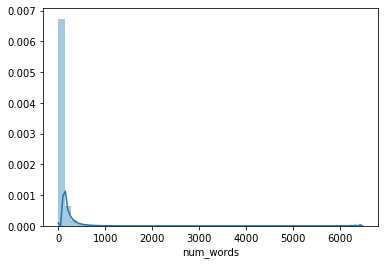

In [21]:
sns.distplot(el['num_words'])

We have a heavy right skew, which makes sense- not everybody want to write a novel for a review, but there are those that do. Let's limit our scope to focus more on the lower end.

<AxesSubplot:xlabel='num_words', ylabel='count'>

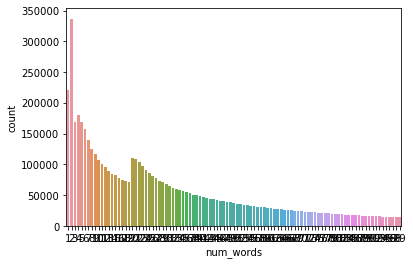

In [29]:
sns.countplot(el[el['num_words'] < 100]['num_words'])

<AxesSubplot:xlabel='num_words', ylabel='count'>

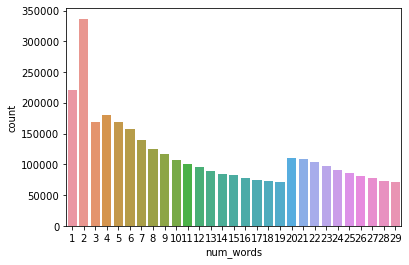

In [28]:
sns.countplot(el[el['num_words'] < 30]['num_words'])


<AxesSubplot:xlabel='num_words', ylabel='overall'>

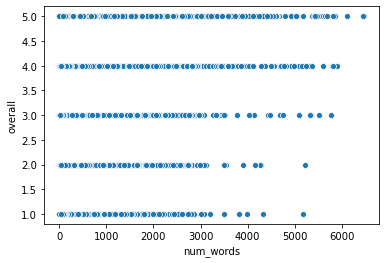

In [30]:
sns.scatterplot(x = 'num_words', y= 'overall', data= el)

In [31]:
el['num_words'].corr(el['overall'])

-0.10369156678250079

Overall, there is essentially no linear relationship between the number of words in the review and the star rating. Furthermore, a good portion of our data consists of reviews with only a few words. This leads us to believe that we probably don't have to worry about cleaning reviews based on length. But for the sheer fun of it, let's take a look at some of these 1-2 word reviews to see if anything stands out.

In [32]:
el[el['num_words'] < 4].head(50)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,num_words
8,5.0,NaN,True,"02 16, 2015",A3UD8JRWLX6SRX,0380709473,Great read!,Five Stars,1424044800,2
19,5.0,NaN,False,"10 29, 2016",A1917RO9OGLVT9,0511189877,Works great!,Five Stars,1477699200,2
20,5.0,NaN,False,"09 20, 2016",AIV2RLRZNV7TC,0511189877,Cool,Awesome,1474329600,1
22,5.0,NaN,True,"08 14, 2016",A17BMVVA8MND5C,0511189877,very nice....,Five Stars,1471132800,2
23,5.0,NaN,True,"07 26, 2016",A24VW8XTD8LSXE,0511189877,Works great,Five Stars,1469491200,2
35,5.0,NaN,True,"08 5, 2015",A3J6X6RXNRHM8V,0511189877,worked. cheap.,if the cable company is a dick. just buy one f...,1438732800,2
37,5.0,NaN,True,"06 30, 2015",A2R8N42G5EDN91,0511189877,great,Five Stars,1435622400,1
38,5.0,NaN,True,"06 10, 2015",A1VJ8WQJ5X5F5M,0511189877,awesome product,Five Stars,1433894400,2
47,5.0,NaN,True,"10 11, 2014",A3EEMBPGLSMFB6,0511189877,IT WORKS WONDERFUL.........,Five Stars,1412985600,3
58,5.0,NaN,True,"08 22, 2013",A3H86FCI0QZH7T,0528881469,It was great.,Five Stars,1377129600,3


Nothing too out of the ordinary here on first glance, but let's try one last analysis to get a more robust picture. Let's convert just these tiny reviews into a bag-of-words model to see the top words, and to see if there are any blaring contradictions.

In [54]:
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english', max_features=100, ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(el[el['num_words'] < 4]['reviewText'])

In [63]:
print(f'words: {cv.get_feature_names()}')
print(text_counts.toarray().sum(axis=0))

words: ['100', 'aaa', 'advertised', 'amazing', 'awesome', 'bad', 'battery', 'best', 'bueno', 'buy', 'cable', 'cables', 'camera', 'card', 'case', 'cheap', 'cool', 'deal', 'described', 'did', 'didn', 'does', 'drive', 'easy', 'exactly', 'excelent', 'excelente', 'excellent', 'expected', 'fantastic', 'fast', 'fine', 'fit', 'fits', 'gift', 'good', 'great', 'handy', 'happy', 'high', 'intended', 'issues', 'item', 'job', 'junk', 'just', 'lens', 'like', 'little', 'looks', 'love', 'loved', 'loves', 'mouse', 'muy', 'needed', 'nice', 'ok', 'okay', 'outstanding', 'perfect', 'perfectly', 'poor', 'pretty', 'price', 'problems', 'product', 'producto', 'promised', 'protection', 'purchase', 'quality', 'really', 'recommend', 'recommended', 'reliable', 'replacement', 'returned', 'right', 's', 'satisfied', 'small', 'solid', 'sound', 'sounds', 'stuff', 'sturdy', 'super', 't', 'thank', 'thanks', 'use', 'useful', 'value', 'wonderful', 'work', 'worked', 'working', 'works', 'worth']
[  1174   1011  16994   2201  

In [58]:
print(cv.vocabulary_)

{'great': 36, 'works': 98, 'cool': 16, 'nice': 56, 'worked': 96, 'cheap': 15, 'awesome': 4, 'product': 66, 'wonderful': 94, 's': 79, 'good': 35, 'item': 42, 'perfectly': 61, 'perfect': 60, 'expected': 28, 'love': 50, 'did': 19, 'work': 95, 'small': 81, 'value': 93, 'excellent': 27, 'ok': 57, 'just': 45, 'advertised': 2, 'fit': 32, 'fine': 31, 'exactly': 24, 'excelente': 26, 'really': 72, 'returned': 77, 't': 88, 'described': 18, 'didn': 20, 'price': 64, 'card': 13, 'job': 43, 'promised': 68, 'thank': 89, 'recommended': 74, 'gift': 34, 'loved': 51, 'quality': 71, 'thanks': 90, 'buy': 9, 'like': 47, 'best': 7, 'fast': 30, 'useful': 92, 'little': 48, 'does': 21, 'muy': 54, 'bueno': 8, 'satisfied': 80, 'handy': 37, 'deal': 17, 'easy': 23, 'happy': 38, 'sturdy': 86, 'use': 91, 'excelent': 25, 'drive': 22, 'intended': 40, 'stuff': 85, 'bad': 5, 'cable': 10, 'high': 39, '100': 0, 'purchase': 70, 'problems': 65, 'working': 97, 'needed': 55, 'looks': 49, 'okay': 58, 'camera': 12, 'right': 78, '

In [69]:
#Let's display this in a more readable way

word_counts = []
text_sums = text_counts.toarray().sum(axis=0)
for item in cv.vocabulary_.items():
    tup = (item[0], text_sums[item[1]])
    word_counts.append(tup)

#sort by most common words first
word_counts.sort(key=lambda x:x[1], reverse = True)
word_counts

[('great', 154910),
 ('works', 124500),
 ('good', 123040),
 ('product', 56597),
 ('excellent', 39823),
 ('nice', 27933),
 ('perfect', 27722),
 ('love', 25743),
 ('ok', 25670),
 ('expected', 19122),
 ('worked', 17658),
 ('advertised', 16994),
 ('quality', 16155),
 ('work', 14385),
 ('fine', 13243),
 ('described', 13086),
 ('thanks', 12403),
 ('awesome', 12325),
 ('item', 8365),
 ('perfectly', 8085),
 ('thank', 7023),
 ('just', 6551),
 ('price', 6241),
 ('excelente', 6164),
 ('job', 6098),
 ('like', 5647),
 ('fit', 5304),
 ('does', 5086),
 ('s', 5004),
 ('case', 4897),
 ('buy', 4769),
 ('excelent', 4637),
 ('value', 4589),
 ('deal', 4489),
 ('cable', 4271),
 ('sound', 4238),
 ('working', 4003),
 ('fast', 3850),
 ('t', 3531),
 ('fits', 3453),
 ('best', 3423),
 ('really', 2538),
 ('cool', 2393),
 ('cheap', 2375),
 ('easy', 2362),
 ('okay', 2249),
 ('satisfied', 2201),
 ('amazing', 2201),
 ('did', 2165),
 ('exactly', 2158),
 ('stuff', 2124),
 ('gift', 2046),
 ('intended', 2041),
 ('super', 

In [51]:
tiny_el = el[el['num_words'] < 4]
tiny_el[tiny_el['reviewText'].str.contains('aaa')].head(50)

,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,num_words
78769,5.0,NaN,True,"01 18, 2017",AU4AHWVX4777F,B0000665UZ,aaa,Five Stars,1484697600,1
93003,4.0,NaN,True,"02 13, 2018",A1VFHC9IE14X3H,B000068O1B,aaaaaaa,Four Stars,1518480000,1
93169,4.0,NaN,True,"02 13, 2018",A1VFHC9IE14X3H,B000068O1D,aaaaaaa,Four Stars,1518480000,1
93327,4.0,NaN,True,"02 13, 2018",A1VFHC9IE14X3H,B000068O18,aaaaaaa,Four Stars,1518480000,1
93469,5.0,NaN,True,"08 3, 2015",A17YHRD5OVH9AA,B000068NYI,chyeaaaaa boiiiii,Five Stars,1438560000,2
106909,3.0,NaN,True,"06 3, 2016",A1XY01IGE7ZTW4,B00006B83E,aaa,Three Stars,1464912000,1
107497,5.0,NaN,True,"10 8, 2015",A1C0RGLZ5F4BR,B00006B9W2,aaa,Five Stars,1444262400,1
188455,5.0,NaN,True,"09 18, 2016",AZ3GAQJUYXO5C,B0000B006W,aaa,Five Stars,1474156800,1
228173,5.0,NaN,True,"06 3, 2016",A1XY01IGE7ZTW4,B0001PFQAI,aaa,Five Stars,1464912000,1
275537,5.0,NaN,True,"02 27, 2017",A2WC2I3A9DCIHF,B0002MQGK4,aaa,Five Stars,1488153600,1


We seem to have a lot of values that just say "aaa" or "t" or the like. These could be the values for people who wrote what they wanted in the summary and didn't want to write an actual review, or they could be bots. Either way, these are probably reviews that should be excluded from training. However, how do we go about testing for other types of these words? We could compare against a corpus, but in that case we need to see in more detail how our spellchecker works (is there a point where it "gives up" and doesn't change the word?) We don't want all these aaaaa's just becoming "a".

### Spellchecking and detecting gibberish

In [ ]:
#placeholder

In [62]:
el.to_csv('electronics_shortened')

In [2]:
el = pd.read_csv('electronics_shortened')

C:\Users\galla\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
el.info()
el.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6738237 entries, 0 to 6738236
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   Unnamed: 0      int64  
 1   overall         float64
 2   vote            object 
 3   verified        bool   
 4   reviewTime      object 
 5   reviewerID      object 
 6   asin            object 
 7   reviewText      object 
 8   summary         object 
 9   unixReviewTime  int64  
 10  num_words       int64  
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 520.5+ MB


,Unnamed: 0,overall,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,num_words
0,0,5.0,67,True,"09 18, 1999",AAP7PPBU72QFM,0151004714,This is the best novel I have read in 2 or 3 y...,A star is born,937612800,197
1,1,3.0,5,True,"10 23, 2013",A2E168DTVGE6SV,0151004714,"Pages and pages of introspection, in the style...",A stream of consciousness novel,1382486400,81
2,2,5.0,4,False,"09 2, 2008",A1ER5AYS3FQ9O3,0151004714,This is the kind of novel to read when you hav...,I'm a huge fan of the author and this one did ...,1220313600,362
3,3,5.0,13,False,"09 4, 2000",A1T17LMQABMBN5,0151004714,What gorgeous language! What an incredible wri...,The most beautiful book I have ever read!,968025600,233
4,4,3.0,8,True,"02 4, 2000",A3QHJ0FXK33OBE,0151004714,I was taken in by reviews that compared this b...,A dissenting view--In part.,949622400,283


# Downsampling

Now that all is said and done, let's take another look at our class balance to see if we should still downsample our data 

<AxesSubplot:xlabel='overall', ylabel='count'>

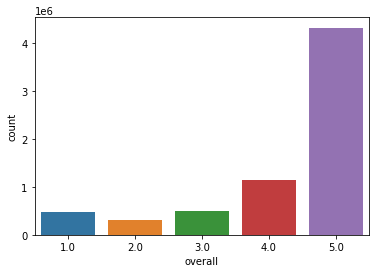

In [75]:
sns.countplot(el['overall'])

In [61]:
rating_counts = el_clean['overall'].value_counts()
rating_counts

5.0    4322520
4.0    1137229
3.0     504712
1.0     467117
2.0     306659
Name: overall, dtype: int64

In [58]:
import imblearn
from collections import Counter
print(imblearn.__version__)

0.8.0


In [59]:
from imblearn.under_sampling import RandomUnderSampler

We'll start with the 5-class downsampler, though we will likely want to downsample separately for each target scheme we use

In [62]:
# Define a randomUnderSampler. Here we set the sampling strategy to downsample until #minority/#class = threshold
# This should help us cut back a bit on removing potentially valuable information (and the distribution)
# while also not affecting the non-5 classes much


def define_sample_counts(rating_counts, threshold):
    min_count = min(rating_counts)
    sample_counts = rating_counts.copy()
    #If class/min_count < threshold, we don't want to downsample (these classes are likely also pseudo minorities)
    sample_counts['sample_target'] = rating_counts.apply(lambda x: int(min_count/threshold) if min_count/x < threshold else int(x))
    
    return sample_counts

sample_counts = define_sample_counts(rating_counts, .5)

under = RandomUnderSampler(sampling_strategy={1: sample_counts['sample_target'][1] , 2: sample_counts['sample_target'][2], 3: sample_counts['sample_target'][3], 4: sample_counts['sample_target'][4], 5: sample_counts['sample_target'][5]})


In [66]:
x = el_clean.drop(['overall', 'pos_neg', 'neutrality'], axis=1)
y = el_clean['overall']

x_under, y_under = under.fit_resample(x, y)
print(Counter(y_under))

Counter({4.0: 613318, 5.0: 613318, 3.0: 504712, 1.0: 467117, 2.0: 306659})


In [73]:
el_downsampled = x_under.join(y_under)
el_downsampled.head()

,Unnamed: 0,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,num_words,overall
0,6738186,NaN,True,"07 21, 2018",AYTXY5M812ZL6,B01HBUHA6S,Sent it back...enough said,One Star,1532131200,4,1.0
1,1796377,NaN,True,"12 2, 2016",A1ITYGP3HOC9JD,B0049S6ZUS,it didn't work with Apple TV - returned it,didn't work with Apple TV,1480636800,9,1.0
2,1379541,5,True,"09 24, 2009",A3M3N4GLK2Y8PG,B0023B14TU,My first camcorder had a battery life of minut...,Must be unlucky,1253750400,111,1.0
3,5582677,NaN,True,"09 12, 2017",A3J4FE8RJ60WFH,B015MPQQ0A,This keyboard was really good while it worked ...,BAD QC DONT BUY,1505174400,85,1.0
4,3554074,4,True,"04 10, 2017",A2KCWWV1YPNNJE,B00DYSKWEO,"Okay, here's the deal. I love this headset fo...",EXTREMELY cheap plastic,1491782400,655,1.0


In [75]:
el_downsampled.to_csv('electronics_downsampled_5_class.csv')

For positive/negative/neutral scheme

In [80]:
rating_counts = el_clean['pos_neg'].value_counts()
rating_counts

positive    5459749
negative     773776
neutral      504712
Name: pos_neg, dtype: int64

In [87]:
sample_counts = define_sample_counts(rating_counts, .5)
sample_counts['sample_target']['positive']

1009424

In [88]:

under_pn = RandomUnderSampler(sampling_strategy={'positive': sample_counts['sample_target']['positive'] , 'negative': sample_counts['sample_target']['negative'], 'neutral': sample_counts['sample_target']['neutral']})

x = el_clean.drop(['overall', 'pos_neg', 'neutrality'], axis=1)
y = el_clean['pos_neg']

x_under, y_under = under_pn.fit_resample(x, y)
print(Counter(y_under))

el_downsampled_pn = x_under.join(y_under)
el_downsampled_pn.head()

Counter({'positive': 1009424, 'negative': 773776, 'neutral': 504712})


,Unnamed: 0,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,num_words,pos_neg
0,4288402,2,True,"01 15, 2017",AD2IZQY0C25XM,B00K9SYPAE,Was really excited for this unit to take with ...,"Beware, Lack of Q.C. !",1484438400,35,negative
1,6449861,NaN,True,"06 2, 2014",A2JE48R9QP7MLD,B00D40B0ES,This compact camera works great and is very in...,Not the best deal.....,1401667200,110,negative
2,2074387,NaN,True,"12 26, 2012",A1QBQLW1ZO5NDX,B0054JE706,I purchased this with an iPad 4th Generation f...,DOES NOT WORK after 1 week,1356480000,192,negative
3,4541949,NaN,True,"12 18, 2015",AHIRI4VEJS8OT,B00MHIP94A,Not sure but whatever it's doing is not what w...,be sure your needs match its capabilites,1450396800,39,negative
4,3005594,NaN,False,"04 13, 2015",A3PQ7HUVTLH1EJ,B00A81SXHI,Update 10/17/2016: This thing has turned into ...,Garbage,1428883200,715,negative


In [91]:
el_downsampled_pn.to_csv('electronics_downsampled_pos_neg_neutral.csv')

Pos/Neg scheme

In [100]:
%%time

#drop all neutral items before downsampling
drop_indices = el_clean[el_clean['pos_neg'] == 'neutral'].index
el_posneg = el_clean.drop(drop_indices, inplace = False)



positive    5459749
negative     773776
neutral      504712
Name: pos_neg, dtype: int64

In [101]:
#Check no positive or negative recors were deleted
rating_counts = el_posneg['pos_neg'].value_counts()
rating_counts

positive    5459749
negative     773776
Name: pos_neg, dtype: int64

In [102]:
#Since this is now a binary classification problem we can just put in a float, 
#and the majority class is automatically chosen to be downsampled relative to the minority class
under_pn = RandomUnderSampler(sampling_strategy= .5 )

x = el_posneg.drop(['overall', 'pos_neg', 'neutrality'], axis=1)
y = el_posneg['pos_neg']

x_under, y_under = under_pn.fit_resample(x, y)
print(Counter(y_under))

el_downsampled_pn_bin = x_under.join(y_under)
el_downsampled_pn_bin.head()

Counter({'positive': 1547552, 'negative': 773776})


,Unnamed: 0,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,num_words,pos_neg
0,16,12,False,"04 14, 2014",A3J3BRHTDRFJ2G,0511189877,"this remote , for whatever reason , ...",Ergonomic nightmare,1397433600,166,negative
1,18,NaN,False,"11 11, 2016",A2OSUEZJIN7BI,0511189877,i have an older url7 remote and thought this w...,Cannot Learn,1478822400,113,negative
2,29,NaN,True,"12 11, 2015",A2R9IT1MU2LOJW,0511189877,volume buttons were dead on arrival . be ...,One Star,1449792000,11,negative
3,54,25,False,"06 21, 2010",A2CPBQ5W4OGBX,0528881469,my brother is a tracker and preorder this . ...,New GPS doesn't work with new Windows 7,1277078400,259,negative
4,55,NaN,True,"02 8, 2016",AIS5NRQWZJCY0,0528881469,works great when i tape up the plug to the po...,plug falls out,1454889600,26,negative


In [103]:
el_downsampled_pn_bin.to_csv('electronics_downsampled_pos_neg_binary.csv')

For neutrality scheme

In [92]:
rating_counts = el_clean['neutrality'].value_counts()
rating_counts

extreme        4789637
non_neutral    1443888
neutral         504712
Name: neutrality, dtype: int64

In [95]:
sample_counts = define_sample_counts(rating_counts, .5)

under_neut = RandomUnderSampler(sampling_strategy={'non_neutral': sample_counts['sample_target']['non_neutral'] , 'extreme': sample_counts['sample_target']['extreme'], 'neutral': sample_counts['sample_target']['neutral']})

x = el_clean.drop(['overall', 'pos_neg', 'neutrality'], axis=1)
y = el_clean['neutrality']

x_under, y_under = under_neut.fit_resample(x, y)
print(Counter(y_under))

el_downsampled_neut = x_under.join(y_under)
el_downsampled_neut.head()

Counter({'extreme': 1009424, 'non_neutral': 1009424, 'neutral': 504712})


,Unnamed: 0,vote,verified,reviewTime,reviewerID,asin,reviewText,summary,unixReviewTime,num_words,neutrality
0,2262820,NaN,True,"12 8, 2014",AX1A5TGV29UP9,B005K96VE0,It's a cable. It has plugs on each end. Since ...,it either works or it doesn't,1417996800,50,extreme
1,1582420,2,True,"11 27, 2014",A2FZMLW3K282X2,B003AIL2HE,I had the wonderful JVC HAFX67 air-fit earbuds...,Suitable replacement for the HAFX67,1417046400,142,extreme
2,3149747,NaN,True,"01 7, 2015",A2GSSPC5WXFF3Y,B00B973X66,Does what it's meant to do. I bought it so i c...,Works Great!,1420588800,20,extreme
3,383548,3,True,"01 27, 2015",A1KIC631L85FHO,B000ALLMI8,"I love it, it can shoot telephoto, and it can ...",Great for telephoto and macro shots. Very vers...,1422316800,37,extreme
4,5580724,2,True,"12 18, 2016",A20YR5KQN1DSUM,B015LZYGMG,I cant go back to plugging in headphones at th...,Absolutely recommend,1482019200,108,extreme


In [96]:
el_downsampled_neut.to_csv('electronics_downsampled_neutrality.csv')

Note: if we want to get really fancy we can try to use cluster-based downsampling, where the downsampled classes are split into clusters and downsampled evenly from them. Trouble is it's a bit harder to cluster text, we'd likely have to use paragraph2Vec style embedding which maybe is just not worth it

### Things to do:

create gibberish detector and run it over reviews with a few words to delete spam reviews

(Maybe) correlate most frequent words with ratings to see if we see anything funny?

### Other considerations:

should we try normalizing review scores by user? Should we aggregate into binary labels?

if we want to get really fancy we can try to use cluster-based downsampling, where the downsampled classes are split into clusters and downsampled evenly from them. Trouble is it's a bit harder to cluster text, we'd likely have to use paragraph2Vec style embedding which maybe is just not worth it

Filtering by verified and/or helpfulness scores of review?

Include review summary in our text? Will probably increase our accuracy a good deal, but might also not make sense for the problem if we are trying to just classify reviews. For instance, a lot of review summaries straight up say "five stars" which might be sort of cheating?

## Target groupings

5-class

Binary positive/negative - 4-5 positive, 1-2 negative, exclude 3

Binary neutral vs non-neutral- 1 and 5 neutral, 3 neutral

3-class- 4-5 positive, 1-2 negative, 3 neutral

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(el[el['num_words'] < 4]['reviewText'])

from spell_check import fixSentence
df['reviewText'] = df['reviewText'].apply(lambda x: fixSentence(x))

print('CHECKPOINT: Spell Check Complete')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

depth = [int(x) for x in np.linspace(10, 40, num = 5)]
estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 5)]

rf = RandomForestClassifier()
grid = {'max_depth': depth, 'n_estimators': estimators}
GS_object = GridSearchCV(estimator = rf, param_grid = grid)

from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
text_counts = cv.fit_transform(df['reviewText'])

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text_counts, df['overall'], test_size = 0.25, random_state = 5)

GS_object.fit(X_train, y_train)

from sklearn import metrics
#train scores
train_predicted = GS_object.predict(X_train)
train_accuracy_score = metrics.accuracy_score(y_train, train_predicted)
train_f1_score = metrics.f1_score(y_train, train_predicted, average = 'macro')
print(str('{:04.2f}'.format(train_accuracy_score*100))+'%')
print(train_f1_score)

#test scores
test_predicted = GS_object.predict(X_test)
test_accuracy_score = metrics.accuracy_score(y_test, test_predicted)
test_f1_score = metrics.f1_score(y_test, test_predicted, average = 'macro')
print(str('{:04.2f}'.format(train_accuracy_score*100))+'%')
print(test_f1_score)

# Embeddings and Data Loading

In [38]:
!pip install gensim==3.8
!pip install torchtext==0.4.0
!pip install unidecode
!pip install d2l
pip install torchvision

  Created wheel for gensim: filename=gensim-3.8.0-cp37-cp37m-win_amd64.whl size=23718069 sha256=3fd605a4f38e3afa821d19ec1fad2265ca2319fc3a20d1658a75236b0ef14de8
  Stored in directory: c:\users\galla\appdata\local\pip\cache\wheels\97\76\35\1143c6fcbd7bb620c7644e234180531956f17850e07557f18f
Successfully built gensim


In [4]:
import re
import os
import sys
import math
import time
import nltk
import torch
import random
import string
import unidecode
import collections

import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


from gensim.models import Word2Vec
from nltk.corpus import brown
from sklearn.manifold import TSNE
from torch.autograd import Variable
from torchtext import data, datasets
from torchtext.vocab import Vectors

from IPython.display import Image, YouTubeVideo
from torch.nn import functional as F
from d2l import torch as d2l

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def create_word2vec_model(category = 'news', size = 50, sg = 1, min_count = 5):
  try:
    sentences = brown.sents(categories=brown.categories()) 
    model = Word2Vec(sentences, size=size, sg=sg, min_count=min_count)

  except (AttributeError, TypeError):
      raise AssertionError('Input variable "category" should be a string or list,' 
      '"size", "sg", "min_count" should be integers')

  return model

def model_dictionary(model):
  words = list(w2vmodel.wv.vocab)
  return words 

def get_embedding(word, model):
  if word in w2vmodel.wv.vocab:
    return model.wv[word]
  else:
    return None

In [ ]:
w2vmodel = create_word2vec_model(category)

In [ ]:
batch_size = 32 

def load_dataset(sentence_length = 50):
    TEXT = data.Field(sequential=True, tokenize=nltk.word_tokenize, lower=True,
                      include_lengths=True, batch_first=True, fix_length=sentence_length)
    LABEL = data.LabelField(dtype=torch.float)

    train_data, test_data = el_clean.split(split_ratio = .7)

    # If no specific vector embeddings are specified,
    # Torchtext initializes random vector embeddings
    # which would get updated during training through backpropagation.
    
    # Build the vocabulary indexes for our data
    TEXT.build_vocab(train_data)
    LABEL.build_vocab(train_data)
    
    #Create validation set
    train_data, valid_data = train_data.split(split_ratio=0.7)
    
    #creates batches of 
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                   batch_size=batch_size, sort_key=lambda x: len(x.text),
                                                                   repeat=False, shuffle=True)
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, train_iter, valid_iter, test_iter

In [ ]:
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset()

In [ ]:
def train(model, device, train_iter, valid_iter, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    train_loss, validation_loss = [], []
    train_acc, validation_acc = [], []

    for epoch in range(epochs):
      #train
      model.train()
      running_loss = 0.
      correct, total = 0, 0 
      steps = 0

      for idx, batch in enumerate(train_iter):
        text = batch.text[0]
        # print(type(text), text.shape)
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        # add micro for coding training loop
        optimizer.zero_grad()
        output = model(text)
 
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        steps += 1
        running_loss += loss.item()

        # get accuracy 
        _, predicted = torch.max(output, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
        
      train_loss.append(running_loss/len(train_iter))
      train_acc.append(correct/total)

      print(f'Epoch: {epoch + 1},  Training Loss: {running_loss/len(train_iter):.4f}, Training Accuracy: {100*correct/total: .2f}%')

      # evaluate on validation data
      model.eval()
      running_loss = 0.
      correct, total = 0, 0 

      with torch.no_grad():
        for idx, batch in enumerate(valid_iter):
            text = batch.text[0]
            target = batch.label
            target = torch.autograd.Variable(target).long()
            text, target = text.to(device), target.to(device)

            optimizer.zero_grad()
            output = model(text)
    
            loss = criterion(output, target)
            running_loss += loss.item()

            # get accuracy 
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

      validation_loss.append(running_loss/len(valid_iter))
      validation_acc.append(correct/total)

      print (f'Validation Loss: {running_loss/len(valid_iter):.4f}, Validation Accuracy: {100*correct/total: .2f}%')
  
    return train_loss, train_acc, validation_loss, validation_acc

def test(model,  device, test_iter):
  model.eval()
  correct = 0
  total = 0
  with torch.no_grad():
    for idx, batch in enumerate(test_iter):
        text = batch.text[0]
        target = batch.label
        target = torch.autograd.Variable(target).long()
        text, target = text.to(device), target.to(device)

        outputs = model(text)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    acc = 100 * correct / total
    return acc

In [ ]:
def plot_train_val(x, train, val, train_label, val_label, title):
  with plt.xkcd():
    plt.plot(x, train, label=train_label)
    plt.plot(x, val, label=val_label)
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.title(title)
    plt.show()

def count_parameters(model):
    parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return parameters

def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_size, kernel_sizes, num_channels,
                 **kwargs):
        super(TextCNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.fc = nn.Linear(sum(num_channels), 2)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.relu = nn.ReLU()
        self.convs = nn.ModuleList()
        # This for loop adds the Conv1D layers to your network
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(embed_size, c, k))

    def forward(self, inputs):
        embeddings = self.embedding(inputs)
        embeddings = embeddings.permute(0, 2, 1)
        # Concatenating the average-pooled outputs 
        encoding = torch.cat([
            torch.squeeze(self.relu(self.pool(conv(embeddings))), dim=-1)
            for conv in self.convs], dim=1)
        
        outputs = self.fc(encoding)
        return outputs

# Uncomment to test
sampleCNN = TextCNN(1000, 300, [1, 2, 3], [10, 20, 30])
print(sampleCNN)

In [ ]:
# Model hyperparameters
learning_rate = 0.00001
embedding_length = 100
kernel_sizes = [3, 4, 5]
nums_channels = [100, 100, 100]
epochs = 10

# Initialize model, training and testing
cnn_model = TextCNN(vocab_size, embedding_length, kernel_sizes, nums_channels)
cnn_model.to(device)
cnn_model.apply(init_weights)
cnn_start_time = time.time()
cnn_train_loss, cnn_train_acc, cnn_validation_loss, cnn_validation_acc = train(cnn_model, device, train_iter, valid_iter, epochs, learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - cnn_start_time))
test_accuracy = test(cnn_model, device, test_iter)
print('Test Accuracy: ',  test_accuracy, '%')

# Plot accuracies
plot_train_val(np.arange(0,epochs), cnn_train_acc, cnn_validation_acc, 'training_accuracy', 'validation_accuracy', 'CNN on IMDB text classification')

# Number of parameters in model
paramters = count_parameters(cnn_model)
print('\n\nNumber of parameters = ',  paramters)

# RNN

## Data Loader

In [5]:
#el = pd.read_csv("electronics_downsampled_5_class.csv")
el_bin = pd.read_csv("electronics_downsampled_pos_neg_binary.csv")

C:\Users\galla\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
el_bin['pos_neg'] = el_bin['pos_neg'].apply(lambda x: 1 if x == 'positive' else 0)


In [7]:
el_bin = el_bin[['reviewText', 'pos_neg']]
el_bin.head()

,reviewText,pos_neg
0,"this remote , for whatever reason , ...",0
1,i have an older url7 remote and thought this w...,0
2,volume buttons were dead on arrival . be ...,0
3,my brother is a tracker and preorder this . ...,0
4,works great when i tape up the plug to the po...,0


In [12]:
el_bin.dropna(inplace=True)

In [7]:
#el_bin['reviewText'] = el_bin['reviewText'].to_string()

In [13]:
el_bin.head()

,reviewText,pos_neg
0,"this remote , for whatever reason , ...",0
1,i have an older url7 remote and thought this w...,0
2,volume buttons were dead on arrival . be ...,0
3,my brother is a tracker and preorder this . ...,0
4,works great when i tape up the plug to the po...,0


In [16]:
%%time
el_bin['reviewText'] = el_bin['reviewText'].apply(lambda x: clean_text(x))

Wall time: 6min 12s


In [17]:
el_bin.head()

,reviewText,pos_neg
0,"this remote , for whatever reason , ...",0
1,i have an older url7 remote and thought this w...,0
2,volume buttons were dead on arrival . b...,0
3,my brother is a tracker and preorder this ....,0
4,works great when i tape up the plug to the po...,0


In [25]:
type(el_bin['pos_neg'][0])

numpy.float64

In [21]:
el_bin2 = el_bin.copy()

In [24]:
el_bin['pos_neg'] = el_bin['pos_neg'].apply(lambda x: np.float16(x) )

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train_data, test_data = train_test_split(el_bin, test_size = 0.2)
train_data.head()

,reviewText,pos_neg
1469355,exactly what i expected . ipad cases are hard...,1.0
452168,did not work great for me .,0.0
494877,i would not recommend this product due to coup...,0.0
936223,i am glad that i bought this for my expensive ...,1.0
1113044,woeks as it should,1.0


In [13]:
el_tensor = torch.tensor(el_bin.values)
train_data, test_data = el_tensor.split(split_ratio=0.8)
el_tensor

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [26]:
from torch.utils.data import TensorDataset, DataLoader

In [135]:
el_text = el_bin['reviewText'].to_numpy()
el_labels = el_bin['pos_neg'].to_numpy()

In [136]:
el_data = TensorDataset(torch.from_numpy(el_text), torch.from_numpy(el_labels))

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [119]:

el_tensor = torch.from_numpy(el_bin)
train_data, test_data = el_tensor.split(split_ratio=0.8)
el_tensor

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint8, and bool.

In [154]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
def tokenize(sentence):
  tokens = token.tokenize(sentence)
  filtered = [x for x in tokens]
  return filtered

el_bin['tokenized'] = el_bin['reviewText'].apply(tokenize)
el_bin = el_bin[['tokenized', 'overall']]
el_bin.head()

KeyboardInterrupt: 

In [38]:
%%time

from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import WhitespaceTokenizer
#from nltk.tokenize import word_tokenize
token = RegexpTokenizer(r"[a-zA-Z0-9.,;!?]+")

#token = WordPunctTokenizer()
#token = WhitespaceTokenizer()
#token = StringTokenizer()

def tokenize(sentence):
    return token.tokenize(sentence)



el_bin['tokenized'] = el_bin['reviewText'].apply(lambda x: token.tokenize(x))


Wall time: 1min 34s


In [39]:
el_bin = el_bin[['tokenized', 'pos_neg']]
el_bin.head()

,tokenized,pos_neg
0,"[this, remote, ,, for, whatever, reason, ,, wa...",0.0
1,"[i, have, an, older, url7, remote, and, though...",0.0
2,"[volume, buttons, were, dead, on, arrival, ., ...",0.0
3,"[my, brother, is, a, tracker, and, preorder, t...",0.0
4,"[works, great, when, i, tape, up, the, plug, t...",0.0


In [15]:
train_df, test_df = train_test_split(el_bin, test_size = 0.2, random_state = 42)
train_json = train_df.to_json(orient = 'records')
train_json_result = json.loads(train_json)
with open('elec_bin_train.json', 'w') as f:
    for entry in train_json_result:
        json.dump(entry, f)
        f.write('\n')

OverflowError: Could not reserve memory block

In [40]:
train_df, test_df = train_test_split(el_bin, test_size = 0.2, random_state = 42)
train_df.to_csv('el_bin_train.csv')
test_df.to_csv('el_bin_test.csv')

In [35]:
el_bin.to_csv('electronics_pn_binary_cleaned.csv')

In [11]:
test_json = test_df.to_json(orient = 'records')
test_json_result = json.loads(test_json)
with open('elec_bin_test.json', 'w') as f:
    for entry in test_json_result:
        json.dump(entry, f)
        f.write('\n')

OverflowError: Could not reserve memory block

In [171]:
import torch


TOKENS = data.Field(tokenize = nltk.word_tokenize,
                      include_lengths = True, batch_first = True)
SCORE = data.LabelField(dtype = torch.float)

fields = {'reviewText': ('tokens', TOKENS), 'pos_neg': ('score', SCORE)}
train_data, test_data = data.TabularDataset.splits(
    path = '',
    train = 'el_bin_train.json',
    test = 'el_bin_test.json',
    format = 'json',
    fields = fields
)
print(vars(train_data[0]))

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [41]:
import torch



TEXT = data.Field(tokenize = nltk.word_tokenize, include_lengths = True, batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

fields = [('reviewText', TEXT), ('pos_neg'), LABEL]
train_data, test_data = data.TabularDataset.splits(
    path = '',
    train = 'el_bin_train.csv',
    test = 'el_bin_test.csv',
    format = 'csv',
    skip_header = False,
    fields = fields
)
print(vars(train_data[0]))

OverflowError: Python int too large to convert to C long

In [31]:
print(vars(train_data[0]))

KeyError: 0

In [ ]:
'''def dynamic_pad(batch, vocab):
    pad_idx = vocab.stoi['<pad>']
        for idx, ex in enumerate(batch):
            if len(ex) < min_length:
                batch[idx] = ex + [pad_idx] * (min_length - len(ex))
        return batch'''
    
def dynamic_pad(batch):
    size = len(batch[0])
    #get the lengths of the token lists in the batch
    lens = []
    for item in batch['':
        
    # Just to make the function more robust, we allow it to handle data that hasn't been separated from the label
    if size == 3:
        texts, lens, y = zip(*batch)
    else:
        texts, lens = zip(*batch)
    lens = np.array(lens)

In [176]:
batch_size = 32 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_dataset(dataset):
    TEXT = data.Field(tokenize = nltk.word_tokenize,
                      include_lengths = True, batch_first = True)
    LABEL = data.LabelField(dtype = torch.float)

    fields = {'reviewText': ('text', TEXT), 'pos_neg': ('label', LABEL)}
    train_data, test_data = data.TabularDataset.splits(
        path = '',
        train = 'el_bin_train.json',
        test = 'el_bin_test.json',
        format = 'json',
        fields = fields
    )
    
    #dataset = dataset.to_numpy()
    
    #train_data, test_data = train_test_split(dataset, test_size = 0.2, random_state =42)
    

    TEXT.build_vocab(train_data, vectors = "glove.6B.100d", unk_init = torch.Tensor.normal_)
    LABEL.build_vocab(train_data)

    #train_data, valid_data = train_data.split(split_ratio=0.8, random_state = random.seed(seed))
    train_data, valid_data = train_test_split(train_data, test_size = 0.2)
    train_iter, valid_iter, test_iter = data.BucketIterator.splits((train_data, valid_data, test_data),
                                                                   batch_size=batch_size, sort_key=lambda x: len(x.text),
                                                                   repeat=False, shuffle=True)
    vocab_size = len(TEXT.vocab)

    return TEXT, vocab_size, train_iter, valid_iter, test_iter

In [ ]:
train_data

In [179]:
TEXT, vocab_size, train_iter, valid_iter, test_iter = load_dataset(el_bin)

TypeError: '<' not supported between instances of 'NoneType' and 'str'

In [ ]:
def text_from_dict(arr, dictionary):
  text = []
  for element in arr:
    text.append(dictionary[element])
  return text

for idx, batch in enumerate(train_iter):
    text = batch.text[0]
    target = batch.label

    for itr in range(25,30):
      print('Review: ', ' '.join(text_from_dict(text[itr], TEXT.vocab.itos)))
      print('Label: ', int(target[itr].item()), '\n')
   
    print('[0: Negative Review, 1: Positive Review]')
    if idx==0:
      break

## Architecture

In [57]:
class VanillaRNN(nn.Module):
  def __init__(self, output_size, hidden_size, vocab_size, embed_size):
    super(VanillaRNN, self).__init__()

    self.hidden_size = hidden_size
    
    self.word_embeddings = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.RNN(embed_size, hidden_size, num_layers=2)
    self.fc = nn.Linear(2*hidden_size, output_size)

  def forward(self, inputs):
    input = self.word_embeddings(inputs)
    input = input.permute(1, 0, 2)
    h_0 =  Variable(torch.zeros(2, input.size()[1], self.hidden_size).to(device)) 
    output, h_n = self.rnn(input, h_0)
    h_n = h_n.permute(1, 0, 2) 
    h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
    logits = self.fc(h_n)
    
    return logits

# Uncomment to test
sampleRNN = VanillaRNN(10, 50, 1000, 300)
print(sampleRNN)

VanillaRNN(
  (word_embeddings): Embedding(1000, 300)
  (rnn): RNN(300, 50, num_layers=2)
  (fc): Linear(in_features=100, out_features=10, bias=True)
)


In [ ]:
class RNN2(nn.Module):
  def __init__(self, output_size, hidden_size, vocab_size, embed_size):
    super(VanillaRNN, self).__init__()

    self.hidden_size = hidden_size
    
    self.word_embeddings = nn.Embedding(vocab_size, embed_size)
    self.rnn = nn.GRU(embed_size, hidden_size, num_layers=2)
    self.fc = nn.Linear(2*hidden_size, output_size)

  def forward(self, inputs):
    input = self.word_embeddings(inputs)
    input = input.permute(1, 0, 2)
    h_0 =  Variable(torch.zeros(2, input.size()[1], self.hidden_size).to(device)) 
    output, h_n = self.rnn(input, h_0)
    h_n = h_n.permute(1, 0, 2) 
    h_n = h_n.contiguous().view(h_n.size()[0], h_n.size()[1]*h_n.size()[2])
    logits = self.fc(h_n)
    
    return logits

# Uncomment to test
sampleRNN = VanillaRNN(10, 50, 1000, 300)
print(sampleRNN)

In [ ]:
# Model hyperparamters
learning_rate = 0.0002
output_size = 2
hidden_size = 100 
embedding_length = 100
epochs = 10

# Initialize model, training and testing
vanilla_rnn_model = VanillaRNN(output_size, hidden_size, vocab_size, embedding_length)
vanilla_rnn_model.to(device)
vanilla_rnn_start_time = time.time()
vanilla_train_loss, vanilla_train_acc, vanilla_validation_loss, vanilla_validation_acc = train(vanilla_rnn_model, device, train_iter, valid_iter, epochs, learning_rate)
print("--- Time taken to train = %s seconds ---" % (time.time() - vanilla_rnn_start_time))
test_accuracy = test(vanilla_rnn_model, device, test_iter)
print('Test Accuracy: ',  test_accuracy, '%')

# Plot accuracy curves
plot_train_val(np.arange(0,epochs), vanilla_train_acc, vanilla_validation_acc,
               'training_accuracy', 'validation_accuracy', 'Vanilla RNN on IMDB text classification')

# Number of model parameters
paramters = count_parameters(vanilla_rnn_model)
print('\n\nNumber of parameters = ',  paramters)

In [ ]:
class BiRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 **kwargs):
        super(BiRNN, self).__init__(**kwargs)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # Set `bidirectional` to True to get a bidirectional recurrent neural
        # network
        self.encoder = nn.LSTM(embed_size, num_hiddens, num_layers=num_layers,
                               bidirectional=True)
        self.decoder = nn.Linear(4 * num_hiddens, 2)

    def forward(self, inputs):
        # The shape of `inputs` is (batch size, no. of words). Because LSTM
        # needs to use sequence as the first dimension, the input is
        # transformed and the word feature is then extracted. The output shape
        # is (no. of words, batch size, word vector dimension).
        embeddings = self.embedding(inputs.T)
        # Since the input (embeddings) is the only argument passed into
        # nn.LSTM, both h_0 and c_0 default to zero.
        # we only use the hidden states of the last hidden layer
        # at different time step (outputs). The shape of `outputs` is
        # (no. of words, batch size, 2 * no. of hidden units).
        self.encoder.flatten_parameters()
        outputs, _ = self.encoder(embeddings)
        # Concatenate the hidden states of the initial time step and final
        # time step to use as the input of the fully connected layer. Its
        # shape is (batch size, 4 * no. of hidden units)
        encoding = torch.cat((outputs[0], outputs[-1]), dim=1)
        outs = self.decoder(encoding)
        return outs

In [ ]:
embed_size, num_hiddens, num_layers, devices = 100, 100, 2, d2l.try_all_gpus()
net = BiRNN(len(vocab), embed_size, num_hiddens, num_layers)

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)
    if type(m) == nn.LSTM:
        for param in m._flat_weights_names:
            if "weight" in param:
                nn.init.xavier_uniform_(m._parameters[param])

net.apply(init_weights);